In [8]:
from detr_config import Config
from detr_factory import DETRFactory
from detr_file_manager import FileManager
from detr_model_loader import ModelLoader
from detr_data_source import DataSource
from detr_model_evaluator import ModelEvaluator

Config.set_local_settings()

In [9]:
hyperparameters = ('DETR', 100, 6)
detr_factory = DETRFactory(*hyperparameters)
image_processor = detr_factory.new_image_processor()
model_name = detr_factory.get_model_name()
file_manager = FileManager(model_name)
data_source = DataSource(image_processor, file_manager)
model_loader = ModelLoader(detr_factory, file_manager)

file_manager.set_testing_setup()
model = model_loader.load_best_model()
train_valid_dataset, train_valid_loader = data_source.get_train_valid_dataset_dataloader()
test_dataset, test_loader = data_source.get_test_dataset_dataloader()

Loading Model:  lightning_logs\model=DETR_queries=100_layers=6\test\checkpoints\epoch=0-step=1.ckpt
Loading Annotations from:  InBreast_Coco\train_valid\_annotations.coco.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading Annotations from:  InBreast_Coco\test\_annotations.coco.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [12]:
model_evaluator = ModelEvaluator(model, image_processor, test_dataset, test_loader)

batch = next(iter(test_loader))
predictions = model_evaluator.generate_coco_predictions(batch, threshold=0.01)
print(len(predictions))

200


In [12]:
pixel_values, labels = test_dataset.__getitem__(6)
image_id = labels['image_id'].item()
image_data = test_dataset.coco.loadImgs(image_id)[0]

image = Image.open(os.path.join(test_dir, image_data['file_name']))
annotations = test_dataset.coco.imgToAnns[image_id]

with torch.no_grad():
    model.eval()
    outputs = model(
        pixel_values = pixel_values.unsqueeze(0),
        pixel_mask = torch.ones(1,800,800)
    )

postprocessed_outputs = image_processor.post_process_object_detection(
                            outputs, target_sizes=[(800, 800)], threshold=0.9, )

results = postprocessed_outputs[0]

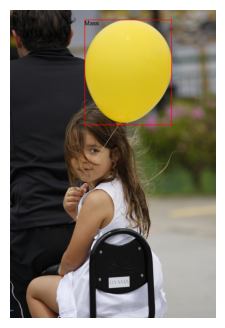

In [13]:
plot_annotations(image.copy(), annotations, id2label)


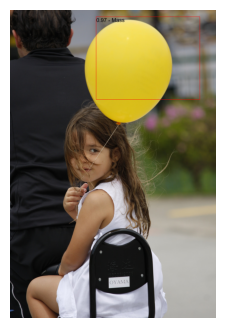

In [14]:
plot_results(image.copy(), results, id2label)